### **AutoML: Build a TCNForecaster (DNN) model for GitHub DAU Forecasting**

Copyright (c) Microsoft Corporation. All rights reserved.

Licensed under the MIT License.

Some adaptations are made, original source: https://github.com/Azure/azureml-examples/blob/main/v1/python-sdk/tutorials/automl-with-azureml/forecasting-github-dau/auto-ml-forecasting-github-dau.ipynb

#### **Introduction**
This notebook demonstrates demand forecasting for Github Daily Active Users Dataset using AutoML.

AutoML highlights here include using Deep Learning forecasts, Arima, Prophet,  Remote Execution and Remote Inferencing, and working with the `forecast` function. Please also look at the additional forecasting notebooks, which document lagging, rolling windows, forecast quantiles, other ways to use the forecast function, and forecaster deployment.

Notebook synopsis:

1. Creating an Experiment in an existing Workspace
2. Configuration and remote run of AutoML for a time-series model exploring DNNs
3. Evaluating the fitted model using a rolling test 
4. Model registration

code files:
- helper.py
- infer.py

data files: 
- github_dau_2011-2018_train.csv
- github_dau_2011-2018_test.csv

***
#### **Setup**


In [1]:
import os
import azureml.core
import pandas as pd
import numpy as np
import logging
import warnings

from pandas.tseries.frequencies import to_offset

# Squash warning messages for cleaner output in the notebook
warnings.showwarning = lambda *args, **kwargs: None

from azureml.core import Workspace, Experiment, Dataset
from azureml.train.automl import AutoMLConfig
from matplotlib import pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from azureml.train.estimator import Estimator

This notebook is compatible with Azure ML SDK version 1.35.0 or later.

In [2]:
print("You are currently using version", azureml.core.VERSION, "of the Azure ML SDK")

You are currently using version 1.53.0 of the Azure ML SDK


As part of the setup you have already created a <b>Workspace</b>. To run AutoML, you also need to create an <b>Experiment</b>. An Experiment corresponds to a prediction problem you are trying to solve, while a Run corresponds to a specific approach to the problem.

In [3]:
ws = Workspace.from_config()

# choose a name for the run history container in the workspace
experiment_name = "github-remote-cpu-dau"

experiment = Experiment(ws, experiment_name)

output = {}
#output["Subscription ID"] = ws.subscription_id
output["Workspace"] = ws.name
output["Resource Group"] = ws.resource_group
output["Location"] = ws.location
output["Run History Name"] = experiment_name
output["SDK Version"] = azureml.core.VERSION
pd.set_option("display.max_colwidth", None)
outputDf = pd.DataFrame(data=output, index=[""])
outputDf.T

,
Workspace,amldemo
Resource Group,azuremachinelearning_demo
Location,westeurope
Run History Name,github-remote-cpu-dau
SDK Version,1.53.0


**Using AmlCompute**

You will need to create a [compute target](https://docs.microsoft.com/azure/machine-learning/service/concept-azure-machine-learning-architecture#compute-target) for your AutoML run. In this tutorial, you use `AmlCompute` as your training compute resource.

> Note that if you have an AzureML Data Scientist role, you will not have permission to create compute resources. Talk to your workspace or IT admin to create the compute targets described in this section, if they do not already exist.

In [4]:
from azureml.core.compute import ComputeTarget, AmlCompute
from azureml.core.compute_target import ComputeTargetException

# Choose a name for your CPU cluster
cpu_cluster_name = "github-dau-cluster"

# Verify that cluster does not exist already
try:
    compute_target = ComputeTarget(workspace=ws, name=cpu_cluster_name)
    print("Found existing cluster, use it.")
except ComputeTargetException:
    compute_config = AmlCompute.provisioning_configuration(
        vm_size="STANDARD_DS12_V2", max_nodes=12
    )
    compute_target = ComputeTarget.create(ws, cpu_cluster_name, compute_config)

compute_target.wait_for_completion(show_output=True)

Found existing cluster, use it.
Succeeded
AmlCompute wait for completion finished

Minimum number of nodes requested have been provisioned


***
#### **Data**
Read Github DAU data from file, and preview data.

Let's set up what we know about the dataset. 

**Target column** is what we want to forecast.

**Time column** is the time axis along which to predict.

**Time series identifier columns** are identified by values of the columns listed `time_series_id_column_names`, for example "store" and "item" if your data has multiple time series of sales, one series for each combination of store and item sold.

**Forecast frequency (freq)** This optional parameter represents the period with which the forecast is desired, for example, daily, weekly, yearly, etc. Use this parameter for the correction of time series containing irregular data points or for padding of short time series. The frequency needs to be a pandas offset alias. Please refer to [pandas documentation](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#dateoffset-objects) for more information.

This dataset has only one time series. Please see the [orange juice notebook](https://github.com/Azure/MachineLearningNotebooks/tree/master/how-to-use-azureml/automated-machine-learning/forecasting-orange-juice-sales) for an example of a multi-time series dataset.

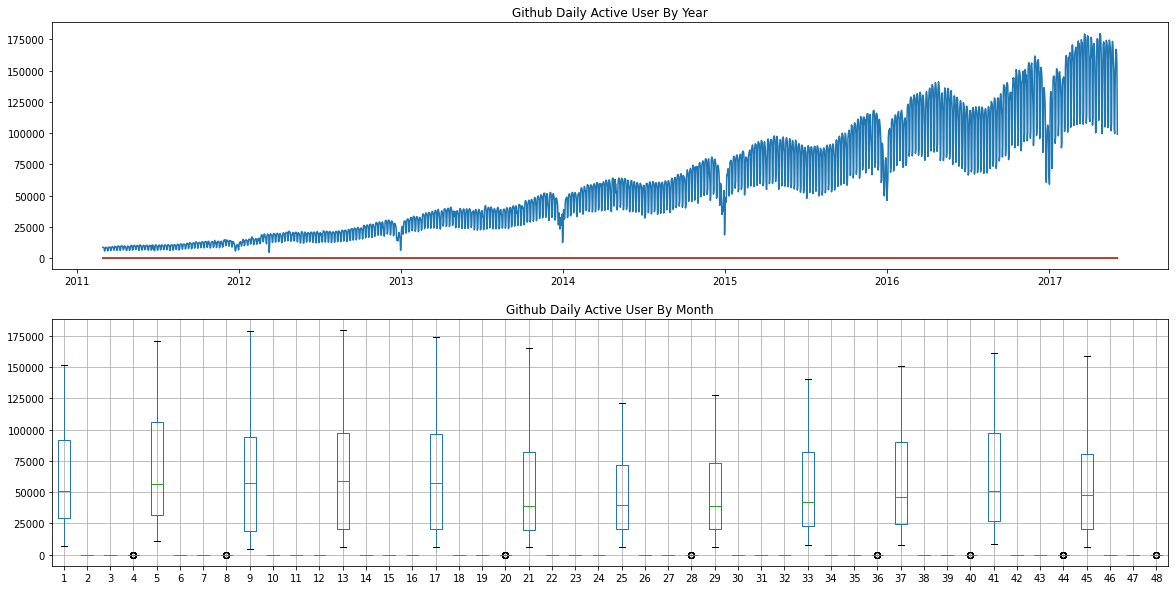

In [5]:
import pandas as pd
from pandas import DataFrame
from pandas import Grouper
from pandas import concat
from pandas.plotting import register_matplotlib_converters

register_matplotlib_converters()
plt.figure(figsize=(20, 10))
plt.tight_layout()

plt.subplot(2, 1, 1)
plt.title("Github Daily Active User By Year")
df = pd.read_csv("github_dau_2011-2018_train.csv", parse_dates=True, index_col="date")
test_df = pd.read_csv(
    "github_dau_2011-2018_test.csv", parse_dates=True, index_col="date"
)
plt.plot(df)

plt.subplot(2, 1, 2)
plt.title("Github Daily Active User By Month")
groups = df.groupby(df.index.month)
months = concat([DataFrame(x[1].values) for x in groups], axis=1)
months = DataFrame(months)
months.columns = range(1, 49)
months.boxplot()

plt.show()

In [6]:
target_column_name = "count"
time_column_name = "date"
time_series_id_column_names = []
freq = "D"  # Daily data

**Split Training data into Train and Validation set and Upload to Datastores**

In [7]:
from helper import split_fraction_by_grain
from helper import split_full_for_forecasting

train, valid = split_full_for_forecasting(df, time_column_name)

# Reset index to create a Tabualr Dataset.
train.reset_index(inplace=True)
valid.reset_index(inplace=True)
test_df.reset_index(inplace=True)

datastore = ws.get_default_datastore()
train_dataset = Dataset.Tabular.register_pandas_dataframe(
    train, target=(datastore, "dataset/"), name="Github_DAU_train"
)
valid_dataset = Dataset.Tabular.register_pandas_dataframe(
    valid, target=(datastore, "dataset/"), name="Github_DAU_valid"
)
test_dataset = Dataset.Tabular.register_pandas_dataframe(
    test_df, target=(datastore, "dataset/"), name="Github_DAU_test"
)

Validating arguments.
Arguments validated.
Successfully obtained datastore reference and path.
Uploading file to dataset//8fd1ba84-6195-4ed6-96fe-eafe7401e22b/
Successfully uploaded file to datastore.
Creating and registering a new dataset.
Successfully created and registered a new dataset.
Validating arguments.
Arguments validated.
Successfully obtained datastore reference and path.
Uploading file to dataset//788c06e6-40c2-46de-bcb9-6a4dd9d8db2e/
Successfully uploaded file to datastore.
Creating and registering a new dataset.
Successfully created and registered a new dataset.
Validating arguments.
Arguments validated.
Successfully obtained datastore reference and path.
Uploading file to dataset//f5148828-4b55-41e2-bf89-b83379d65097/
Successfully uploaded file to datastore.
Creating and registering a new dataset.
Successfully created and registered a new dataset.


**Setting forecaster maximum horizon** 

The forecast horizon is the number of periods into the future that the model should predict. Here, we set the horizon to 14 periods (i.e. 14 days). Notice that this is much shorter than the number of months in the test set; we will need to use a rolling test to evaluate the performance on the whole test set. For more discussion of forecast horizons and guiding principles for setting them, please see the [energy demand notebook](https://github.com/Azure/MachineLearningNotebooks/tree/master/how-to-use-azureml/automated-machine-learning/forecasting-energy-demand).  

In [7]:
forecast_horizon = 14

***
#### **Train**

Instantiate a AutoMLConfig object. This defines the settings and data used to run the experiment.

|Property|Description|
|-|-|
|**task**|forecasting|
|**primary_metric**|This is the metric that you want to optimize.<br> Forecasting supports the following primary metrics <br><i>spearman_correlation</i><br><i>normalized_root_mean_squared_error</i><br><i>r2_score</i><br><i>normalized_mean_absolute_error</i>
|**iteration_timeout_minutes**|Time limit in minutes for each iteration.|
|**training_data**|Input dataset, containing both features and label column.|
|**label_column_name**|The name of the label column.|
|**enable_dnn**|Enable Forecasting DNNs|


In [16]:
from azureml.automl.core.forecasting_parameters import ForecastingParameters

forecasting_parameters = ForecastingParameters(
    time_column_name=time_column_name,
    forecast_horizon=forecast_horizon,
    freq="D",  # Set the forecast frequency to be daily
)

# To only allow the TCNForecaster we set the allowed_models parameter to reflect this.
automl_config = AutoMLConfig(
    task="forecasting",
    primary_metric="normalized_root_mean_squared_error",
    experiment_timeout_hours=1,
    training_data=train_dataset,
    label_column_name=target_column_name,
    validation_data=valid_dataset,
    enable_early_stopping=True,
    verbosity=logging.INFO,
    compute_target=compute_target,
    max_concurrent_iterations=12,
    max_cores_per_iteration=-1,
    enable_dnn=True,
    allowed_models=["TCNForecaster"],
    forecasting_parameters=forecasting_parameters,
)

We will now run the experiment, starting with 10 iterations of model search. The experiment can be continued for more iterations if more accurate results are required. Validation errors and current status will be shown when setting `show_output=True` and the execution will be synchronous.

In [ ]:
remote_run = experiment.submit(automl_config, show_output=True)

In [ ]:
# If you need to retrieve a run that already started, use the following code
# from azureml.train.automl.run import AutoMLRun
# remote_run = AutoMLRun(experiment = experiment, run_id = '<replace with your run id>')

Displaying the run objects gives you links to the visual tools in the Azure Portal. Go try them!

**Retrieve the Best Model for Each Algorithm**

Below we select the best pipeline from our iterations. The get_output method on automl_classifier returns the best run and the fitted model for the last fit invocation. There are overloads on get_output that allow you to retrieve the best run and fitted model for any logged metric or a particular iteration.

In [18]:
from helper import get_result_df

summary_df = get_result_df(remote_run)
summary_df

,run_id,primary_metric,Score
run_algorithm,,,
TCNForecaster,AutoML_239689e5-2280-4cd2-bbaa-b0273aa262a2_HD_13,normalized_root_mean_squared_error,0.172796
TCNForecaster,AutoML_239689e5-2280-4cd2-bbaa-b0273aa262a2_HD_23,normalized_root_mean_squared_error,0.168335
TCNForecaster,AutoML_239689e5-2280-4cd2-bbaa-b0273aa262a2_HD_22,normalized_root_mean_squared_error,0.167846
TCNForecaster,AutoML_239689e5-2280-4cd2-bbaa-b0273aa262a2_HD_10,normalized_root_mean_squared_error,0.164112
TCNForecaster,AutoML_239689e5-2280-4cd2-bbaa-b0273aa262a2_HD_9,normalized_root_mean_squared_error,0.162612
TCNForecaster,AutoML_239689e5-2280-4cd2-bbaa-b0273aa262a2_HD_34,normalized_root_mean_squared_error,0.129918
TCNForecaster,AutoML_239689e5-2280-4cd2-bbaa-b0273aa262a2_HD_36,normalized_root_mean_squared_error,0.0527051
TCNForecaster,AutoML_239689e5-2280-4cd2-bbaa-b0273aa262a2_HD_1,normalized_root_mean_squared_error,0.048723
TCNForecaster,AutoML_239689e5-2280-4cd2-bbaa-b0273aa262a2_HD_33,normalized_root_mean_squared_error,0.0466839


In [30]:
from azureml.core.run import Run
from azureml.widgets import RunDetails

forecast_model = "TCNForecaster"
if not forecast_model in summary_df["run_id"]:
    forecast_model = "ForecastTCN"

best_dnn_run_id = summary_df[summary_df["Score"] == summary_df["Score"].min()][
    "run_id"
][forecast_model]

best_dnn_run = Run(experiment, best_dnn_run_id)

In [7]:
# CHECKPOINT 
from azureml.core.run import Run
from azureml.widgets import RunDetails

ws = Workspace.from_config()

# choose a name for the run history container in the workspace
experiment_name = "github-remote-cpu-dau"
experiment = Experiment(ws, experiment_name)

best_dnn_run_id = "AutoML_239689e5-2280-4cd2-bbaa-b0273aa262a2_HD_30"
best_dnn_run = Run(experiment, best_dnn_run_id)

***
#### **Simple evaluation on Test Data**

Interesting read: https://learn.microsoft.com/en-us/AZURE/machine-learning/how-to-configure-auto-train?view=azureml-api-1&tabs=python#test-models-preview

We now use the best fitted model from the AutoML Run to make forecasts for the test set.  

We always score on the original dataset whose schema matches the training set schema.

In [76]:
test_dataset = Dataset.get_by_name(ws, name="Github_DAU_test", version="1")

In [77]:
# preview the first 3 rows of the dataset
test_dataset.take(5).to_pandas_dataframe()

,date,count,day_of_week,month_of_year,holiday
0,2017-06-04,104663,6.0,5.0,0.0
1,2017-06-05,155824,0.0,5.0,0.0
2,2017-06-06,164908,1.0,5.0,0.0
3,2017-06-07,170309,2.0,5.0,0.0
4,2017-06-08,164256,3.0,5.0,0.0


In [78]:
compute_target = ws.compute_targets["github-dau-cluster"]
test_experiment = Experiment(ws, experiment_name + "_test")

In [ ]:
import os
import shutil

script_folder = os.path.join(os.getcwd(), "inference")
os.makedirs(script_folder, exist_ok=True)
shutil.copy("infer.py", script_folder)

In [80]:
forecast_horizon = 14
valid_dataset = Dataset.get_by_name(ws, name="Github_DAU_valid", version="1") 

In [81]:
from azureml.core import ScriptRunConfig
from helper import run_inference

test_run = run_inference(
    test_experiment,
    compute_target,
    script_folder,
    best_dnn_run,
    test_dataset,
    valid_dataset,
    forecast_horizon,
    target_column_name,
    time_column_name,
    freq,
)

In [83]:
test_score = test_run.get_metrics()
test_score

{'run_algorithm': 'TCNForecaster',
 'normalized_root_mean_squared_error': 0.05753822711595518,
 'r2_score': 0.949084720723751,
 'explained_variance': 0.9504843205853573,
 'normalized_median_absolute_error': 0.02442372248903968,
 'normalized_root_mean_squared_log_error': 0.0543844118958176,
 'root_mean_squared_error': 7835.153001060965,
 'root_mean_squared_log_error': 0.052857701781269285,
 'normalized_mean_absolute_error': 0.03714000323992327,
 'mean_absolute_percentage_error': 3.319931539441126,
 'spearman_correlation': 0.9653684341488076,
 'median_absolute_error': 3325.8515625,
 'mean_absolute_error': 5057.465661190071,
 'rmse': 7835.153001060965,
 'mae': 5057.465661190071}

look at output of job for predictions

To test other existing automated ML models created, best job or child job, use ModelProxy() to test a model after the main AutoML run has completed. ModelProxy() already returns the predictions and metrics and does not require further processing to retrieve the outputs.

Note: ModelProxy is an experimental preview class, and may change at any time.

The following code demonstrates how to test a model from any run by using ModelProxy.test() method. In the test() method you have the option to specify if you only want to see the predictions of the test run with the include_predictions_only parameter.

source: https://learn.microsoft.com/en-us/AZURE/machine-learning/how-to-configure-auto-train?view=azureml-api-1&tabs=python#test-models-preview

In [95]:
from azureml.train.automl.model_proxy import ModelProxy

model_proxy = ModelProxy(child_run=best_dnn_run, compute_target=compute_target)
predictions, metrics = model_proxy.test(test_dataset, include_predictions_only= False
)

Class ModelProxy: This is an experimental class, and may change at any time. Please see https://aka.ms/azuremlexperimental for more information.


In [ ]:
predictions

In [98]:
from azureml.core import Workspace, Datastore, Dataset

# Connect to your Azure ML workspace
workspace = Workspace.from_config()

# Define the reference to the file in the datastore
datastore_name = "workspaceblobstore"  # Update with your datastore name
datastore_path = "ExperimentRun/dcid.bb034-a312-42ea-ae0f-b4be1a/predictions/predictions.csv"

# Get the default datastore
default_datastore = Datastore.get(workspace, datastore_name)

# Create a Dataset reference to the file
datastore_file = [(default_datastore, datastore_path)]
dataset = Dataset.Tabular.from_delimited_files(datastore_file)

# Load the data into a Pandas DataFrame
dfpredictions = dataset.to_pandas_dataframe()
dfpredictions.head()

,count_orig,count_predicted,date,_automl_dummy_grain_col,index_orig,day_of_week_orig,month_of_year_orig,holiday_orig,_automl_target_col_orig
0,104663,103573.664062,2017-06-04,_automl_dummy_grain_col,0,6.0,5.0,0.0,103573.664062
1,155824,157282.625000,2017-06-05,_automl_dummy_grain_col,1,0.0,5.0,0.0,157282.625000
2,164908,167806.515625,2017-06-06,_automl_dummy_grain_col,2,1.0,5.0,0.0,167806.515625
3,170309,167196.296875,2017-06-07,_automl_dummy_grain_col,3,2.0,5.0,0.0,167196.296875
4,164256,164834.750000,2017-06-08,_automl_dummy_grain_col,4,3.0,5.0,0.0,164834.750000


***
#### **Model Registration**

After you test a model and confirm you want to use it in production, you can register it for later use and
To register a model from an automated ML run, use the register_model() method.

go to setup automl in docs to find guidelines, go deeper via sdk docs (search: register_model sdk azure)

In [18]:
from azureml.core import Model # new sdk is from azure.ai.ml.entities import Model

# Register model
best_dnn_run.register_model(model_path='outputs/model.pt', model_name='TCNForecaster-GitHub-dau', # you find this folder path here by going to the best run, and only there the output
                        tags={'Training context':'Auto ML'}
                        )

# List registered models
for model in Model.list(ws):
    print(model.name, 'version:', model.version)
    for tag_name in model.tags:
        tag = model.tags[tag_name]
        print ('\t',tag_name, ':', tag)

#source: https://learn.microsoft.com/en-us/python/api/azureml-core/azureml.core.model.model?view=azure-ml-py
#source: https://learn.microsoft.com/en-us/AZURE/machine-learning/how-to-configure-auto-train?view=azureml-api-1&tabs=python#test-models-preview

TCNForecaster-GitHub-dau version: 1
	 Training context : Auto ML
uci-small-tcn-model-202309141713 version: 1
	 algorithm : TCNForecaster
	 model_file_name : model.pt
diabetes_model version: 2
	 Training context : Auto ML
AutoMLe512a9b2d36 version: 1
automl_model version: 1
diabetes-automl-best version: 1
diabetes_model version: 1
	 Training context : Pipeline
